In [2]:
# source /data/Xilinx_no_Vitis/Vivado/2020.1/settings64.sh
!vivado -version

vivado v2023.2.1 (64-bit)
Tool Version Limit: 2023.10
SW Build 4081461 on Thu Dec 14 12:22:04 MST 2023
IP Build 4080415 on Thu Dec 14 21:01:57 MST 2023
SharedData Build 4077621 on Mon Dec 11 00:23:44 MST 2023
Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.


In [16]:
import os 
import hashlib

import keras
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score
import numpy as np

from qkeras.qlayers import QDense
from qkeras.quantizers import ternary

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
keras.utils.set_random_seed(32)

## Download data

In [17]:
train_data_dir = "../data/malab_05282024/npz/"
test_data_dir = "../data/malab_05282024/npz/"
start_location = 100
window_size = 400
end_window = start_location + window_size

In [18]:
"""Loadning training split"""
x_train_path = os.path.join(train_data_dir, f'0528_X_train_0_770.npy')
y_train_path = os.path.join(train_data_dir, f'0528_y_train_0_770.npy')

assert os.path.exists(x_train_path), f"ERROR: File {x_train_path} does not exist."
assert os.path.exists(y_train_path), f"ERROR: File {y_train_path} does not exist."

X_train_val = np.load(x_train_path)
y_train_val = np.load(y_train_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_train_val).hexdigest() == 'b61226c86b7dee0201a9158455e08ffb',  "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_train_val).hexdigest() == 'c59ce37dc7c73d2d546e7ea180fa8d31',  "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_train_val = X_train_val[:,start_location*2:end_window*2]
assert len(X_train_val[0]) == (end_window-start_location)*2, f"ERROR: X_test sample size {len(X_train_val[0])} does not match (start window, end window) ({start_location},{end_window}) size."

In [19]:
"""Loading testing split"""
x_test_path = os.path.join(test_data_dir, f'0528_X_test_0_770.npy')
y_test_path = os.path.join(test_data_dir, f'0528_y_test_0_770.npy')

assert os.path.exists(x_test_path), f"ERROR: File {x_test_path} does not exist."
assert os.path.exists(y_test_path), f"ERROR: File {y_test_path} does not exist."

X_test = np.load(x_test_path)
y_test = np.load(y_test_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_test).hexdigest() == 'b7d85f42522a0a57e877422bc5947cde', "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_test).hexdigest() == '8c9cce1821372380371ade5f0ccfd4a2', "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_test = X_test[:,start_location*2:end_window*2]
assert len(X_test[0]) == (end_window-start_location)*2, f"ERROR: X_test sample size {len(X_test[0])} does not match (start window, end window) ({start_location},{end_window}) size."

## Build our model 
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models. We're using QDense layer instead of Dense. We're also training with model sparsity, since QKeras layers are prunable.

In [20]:
keras_model = keras.models.Sequential()
keras_model.add(QDense(
    4, 
    activation=None, 
    name='fc1',
    input_shape=(800,), 
    kernel_quantizer=ternary(),
    bias_quantizer=ternary(),
))
keras_model.add(BatchNormalization(name='batchnorm1'))
keras_model.add(QDense(
    1, 
    name='fc2', 
    activation=None, 
    kernel_quantizer=ternary(),
    bias_quantizer=ternary(),
))

print(keras_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 4)                 3204      
                                                                 
 batchnorm1 (BatchNormalizat  (None, 4)                16        
 ion)                                                            
                                                                 
 fc2 (QDense)                (None, 1)                 5         
                                                                 
Total params: 3,225
Trainable params: 3,217
Non-trainable params: 8
_________________________________________________________________
None


## Load model and check performance

In [21]:
init_learning_rate = 1e-3
validation_split = 0.05  # 45,000 sample size 
batch_size = 256
epochs = 50
early_stopping_patience = 10

checkpoint_dir = f'checkpoints/'
checkpoint_filename = f'qkeras_model_best.h5'

if os.path.exists(checkpoint_dir) == False:
    print(f'Checkpoint directory {checkpoint_dir} does not exist.')
    print('Creating directory...')
    os.mkdir(checkpoint_dir)

In [22]:
keras_model.load_weights(os.path.join(checkpoint_dir, checkpoint_filename))
y_keras = keras_model.predict(X_test)
test_acc = accuracy_score(y_test, np.where(y_keras < 0, 0, 1).reshape(-1))

print('\n===================================')
print(f'Start location = {start_location}, Window size = {window_size}')
print('    Accuracy', test_acc)
print('    Fidelity', test_acc*2-1)


3125/3125 [==============================] - 3s 1ms/step

Start location = 100, Window size = 400
    Accuracy 0.95999
    Fidelity 0.91998


## Convert the model to FPGA firmware 

### Make an hls4ml config and model

In [23]:
import hls4ml

# Create HLS configuration 
hls_config = {}
hls_config['Model'] = {}
hls_config = hls4ml.utils.config_from_keras_model(keras_model, granularity='name')
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'  # Default precision
hls_config['Model']['ReuseFactor'] = 1  # parallelized 
hls_config['Model']['Strategy'] = 'Resource'

keras_layers = ['fc1', 'fc1_alpha', 'fc1_linear', 'batchnorm1', 'fc2', 'fc2_alpha', 'fc2_linear']
for layer in keras_layers:
    hls_config['LayerName'][layer] = {}
    hls_config['LayerName'][layer]['Precision'] = {}
    if 'alpha' in layer: continue
    hls_config['LayerName'][layer]['Trace'] = True

# Input - ZCU216 uses 14-bit ADCS 
hls_config['LayerName']['fc1_input'] = {}
hls_config['LayerName']['fc1_input']['Precision'] = {}
hls_config['LayerName']['fc1_input']['Trace'] = False
hls_config['LayerName']['fc1_input']['Precision'] = 'ap_fixed<14,14>' 

# Fc1
hls_config['LayerName']['fc1']['Precision']['result'] = 'ap_fixed<20,20>'
hls_config['LayerName']['fc1']['accum_t'] = 'ap_fixed<20,20>'

# Fc1 activation 
hls_config['LayerName']['fc1_alpha']['Precision']['result'] = 'ap_fixed<20,20>'
hls_config['LayerName']['fc1_linear']['Precision']['result'] = 'ap_fixed<20,20>'

# Batchnormalization
hls_config['LayerName']['batchnorm1']['Precision']['scale'] = 'ap_fixed<18,4>'
hls_config['LayerName']['batchnorm1']['Precision']['bias'] = 'ap_fixed<18,4>'
hls_config['LayerName']['batchnorm1']['Precision']['result'] = 'ap_fixed<10,4>'
hls_config['LayerName']['batchnorm1']['accum_t'] = 'ap_fixed<10,4>'

# Fc2
hls_config['LayerName']['fc2']['Precision']['result'] = 'ap_fixed<21,21>'
hls_config['LayerName']['fc2']['accum_t'] = 'ap_fixed<21,21>'

# Fc2 activation 
hls_config['LayerName']['fc2_alpha']['Precision']['result'] = 'ap_fixed<21,21>'
hls_config['LayerName']['fc2_linear']['Precision']['result'] = 'ap_fixed<21,21>'

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 800]], output shape: [None, 800]
Layer name: fc1, layer type: QDense, input shapes: [[None, 800]], output shape: [None, 4]
Layer name: batchnorm1, layer type: BatchNormalization, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: fc2, layer type: QDense, input shapes: [[None, 4]], output shape: [None, 1]


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 800]], output shape: [None, 800]
Layer name: fc1, layer type: QDense, input shapes: [[None, 800]], output shape: [None, 4]
Layer name: batchnorm1, layer type: BatchNormalization, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: fc2, layer type: QDense, input shapes: [[None, 4]], output shape: [None, 1]
Creating HLS model


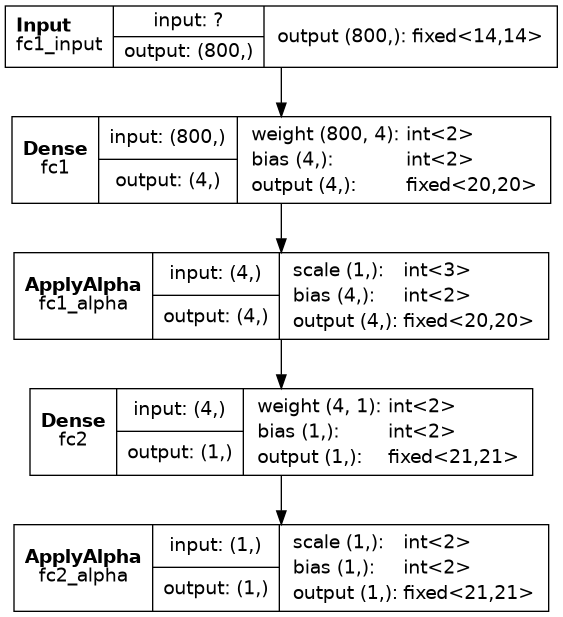

In [24]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model=keras_model,
    hls_config=hls_config,
    output_dir='hls4ml_prj/',
    part= 'xczu49dr-ffvf1760-2-e',
    io_type='io_parallel',
    clock_period=3.225,
    backend='VivadoAccelerator',
    board='zcu216',
    interface='axi_stream',
    project_name='NN'
)

# Visualize model
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

### Compile and predict

In [25]:
hls_model.compile()  # Must compile for C Sim. 
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project


Done


### Compare hls4ml and keras model
#### Accuracy

In [31]:
y_hls = hls_model.predict(np.ascontiguousarray(X_test.astype(np.float32))) 

keras_acc = accuracy_score(y_test, np.where(y_keras <= 0, 0, 1).reshape(-1))
hls_acc = accuracy_score(y_test, np.where(y_hls < 0, 0, 1).reshape(-1))

print(f'Keras Acc: {keras_acc*100:.5}%')
print(f'HLS Acc: {hls_acc*100:.5}:%')

Keras Acc: 95.999%
Keras Fidelity: 91.998%
HLS Acc: 96.022:%
HLS Fidelity: 92.044:%


#### Fidelity 

In [27]:
# get ground and excited indices 
e_indices = np.where(y_test == 1)[0]
g_indices = np.where(y_test == 0)[0]

# separate ground and excited samples 
Xe_test = X_test[e_indices]
ye_test = y_test[e_indices]

Xg_test = X_test[g_indices]
yg_test = y_test[g_indices]

In [32]:
# compute total correct for excited state 
ye_keras = keras_model.predict(Xe_test)
ye_keras = np.where(ye_keras < 0, 0, 1).reshape(-1)
e_accuracy = accuracy_score(ye_test, ye_keras)

total_correct = (ye_test==ye_keras).astype(np.int8).sum()
total_incorrect = (ye_test!=ye_keras).astype(np.int8).sum()

# compute total correct for ground state 
yg_keras = keras_model.predict(Xg_test)
yg_keras = np.where(yg_keras < 0, 0, 1)
g_accuracy = accuracy_score(yg_test, yg_keras)

total_correct = (yg_test==yg_keras).astype(np.int8).sum()
total_incorrect = (yg_test!=yg_keras).astype(np.int8).sum()

# compute fidelity 
keras_fidelity = 0.5*(e_accuracy + g_accuracy)
keras_fidelity = keras_fidelity*2-1
keras_fidelity = 1/2 + (0.5*keras_fidelity)


# compute total correct for excited state 
ye_hls = hls_model.predict(Xe_test)
ye_hls = np.where(ye_hls < 0, 0, 1).reshape(-1)
e_accuracy = accuracy_score(ye_test, ye_hls)

total_correct = (ye_test==ye_hls).astype(np.int8).sum()
total_incorrect = (ye_test!=ye_hls).astype(np.int8).sum()

# compute total correct for ground state 
yg_hls = hls_model.predict(Xg_test)
yg_hls = np.where(yg_hls < 0, 0, 1)
g_accuracy = accuracy_score(yg_test, yg_hls)

total_correct = (yg_test==yg_hls).astype(np.int8).sum()
total_incorrect = (yg_test!=yg_hls).astype(np.int8).sum()

# compute fidelity 
hls_fidelity = 0.5*(e_accuracy + g_accuracy)
hls_fidelity = hls_fidelity*2-1
hls_fidelity = 1/2 + (0.5*hls_fidelity)


print('\n===================================')
print('    Keras Fidelity', keras_fidelity)
print('    HLS Fidelity', hls_fidelity)

1563/1563 [==============================] - 1s 343us/step

    Keras Fidelity 0.979995
    HLS Fidelity 0.98011


### Synthesize 

In [ ]:
hls_model.build(
    csim=False,
    synth=True,
    cosim=False,
    export=False,
    vsynth=True,
)

### Check the report

In [ ]:
hls4ml.report.read_vivado_report('hls4ml_prj/')